#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/lyc.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,8.50,8.53,8.280,8.49,8.49,2299944,1.35,2.5,125.0
5747,28/07/2022,8.65,8.76,8.540,8.72,8.72,3305955,1.35,2.5,125.0
5748,29/07/2022,8.82,8.96,8.615,8.71,8.71,3372723,1.35,2.5,125.0
5749,1/08/2022,8.90,9.17,8.860,9.10,9.10,4382085,1.35,2.5,125.0
5750,2/08/2022,8.90,8.98,8.800,8.88,8.88,3767947,1.35,2.5,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

In [4]:
# # Drop all previous records now in MongoDb
#db.lyc.drop()
# # Insert all the records in the CSV into MongoDb
# Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.lyc.insert_many(records)

In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.lyc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.lyc.delete_one(
    {'Date': last_date}
)

DELETE: 29/08/2022 8.829999923706055


In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.lyc.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 26/08/2022 9.029999732971191
Previous last date in MongoDb: 26-08-2022. Today's date: 30-08-2022


UPDATE MONGO DB

In [7]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'lyc.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote=stock_quote.iloc[1:] #skips first record
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,8.89,8.580,8.73,8.83,5005694,8.83
2022-08-30,8.72,8.375,8.68,8.62,7408395,8.62


In [8]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,8.89,8.580,8.73,8.83,5005694,8.83,1.85,2.5,125
1,30/08/2022,8.72,8.375,8.68,8.62,7408395,8.62,1.85,2.5,125


In [9]:
records=stock_quote.to_dict('records',)
print(records)

[{'Date': '29/08/2022', 'High': 8.890000343322754, 'Low': 8.579999923706055, 'Open': 8.729999542236328, 'Close': 8.829999923706055, 'Volume': 5005694, 'Adj Close': 8.829999923706055, 'RBA': 1.85, 'FED': 2.5, 'CPI': 125}, {'Date': '30/08/2022', 'High': 8.720000267028809, 'Low': 8.375, 'Open': 8.680000305175781, 'Close': 8.619999885559082, 'Volume': 7408395, 'Adj Close': 8.619999885559082, 'RBA': 1.85, 'FED': 2.5, 'CPI': 125}]


In [10]:

db.lyc.insert_many(records)
#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.lyc.find()))
last_vals = df_mongo.iloc[-10:].values
last_vals

array([[ObjectId('62ff42c417c5a785ab857d52'), '17/08/2022',
        9.930000305175781, 10.180000305175781, 9.829999923706055,
        10.119999885559082, 10.119999885559082, 4682643, 1.85, 2.5,
        125.0],
       [ObjectId('62ff42c417c5a785ab857d53'), '18/08/2022',
        10.050000190734863, 10.09000015258789, 9.770000457763672,
        9.8100004196167, 9.8100004196167, 4934613, 1.85, 2.5, 125.0],
       [ObjectId('63035ae10436e1eb2add2d2a'), '19/08/2022',
        9.970000267028809, 9.970000267028809, 9.680000305175781,
        9.720000267028809, 9.720000267028809, 3351074, 1.85, 2.5, 125.0],
       [ObjectId('6304a8b34bc3c10ec7980e01'), '22/08/2022',
        9.359999656677246, 9.529999732971191, 9.149999618530273,
        9.1899995803833, 9.1899995803833, 5058806, 1.85, 2.5, 125.0],
       [ObjectId('63074331776194073b38322a'), '23/08/2022',
        9.020000457763672, 9.130000114440918, 8.869999885559082,
        8.869999885559082, 8.869999885559082, 6080871, 1.85, 2.5, 125.0],
 

In [11]:
import pandas as pd
df_mongo = pd.DataFrame(list(db.lyc.find()))
last_val_10 = df_mongo.iloc[-1:].values
last_date = last_val_10[-1][1]
last_close = last_val_10[-1][5]
print(last_close,last_date)

8.619999885559082 30/08/2022


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.lyc.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(5771, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4617, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.02178009, 0.02077296, 0.01976587, 0.01976587, 0.01976587,
       0.01875878, 0.02178009, 0.01875878, 0.02278718, 0.02278718,
       0.02278718, 0.02278718, 0.02178009, 0.02178009, 0.01875878,
       0.02077296, 0.02077296, 0.02077296, 0.01976587, 0.02077296,
       0.02379427, 0.03185099, 0.03285808, 0.03487226, 0.03688644,
       0.04192193, 0.03789353, 0.04393611, 0.04595029, 0.04796447,
       0.04595029, 0.04595029, 0.04192193, 0.03789353, 0.03990775,
       0.03890066, 0.04192193, 0.03990775, 0.03990775, 0.03789353,
       0.03587935, 0.03285808, 0.03185099, 0.03487226, 0.03688644,
       0.03990775, 0.03789353, 0.03386517, 0.03587935, 0.03587935,
       0.03587935, 0.04192193, 0.03990775, 0.03990775, 0.0449432 ,
       0.03990775, 0.04393611, 0.03990775, 0.03890066, 0.03890066])]
[0.03890066154311104]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4557, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4557, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4557/4557 [==============================] - 199s 43ms/step - loss: 0.0013


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.5006742718562651

C:\Users\antoi\AppData\Local\Temp/ipykernel_38176/3474577724.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


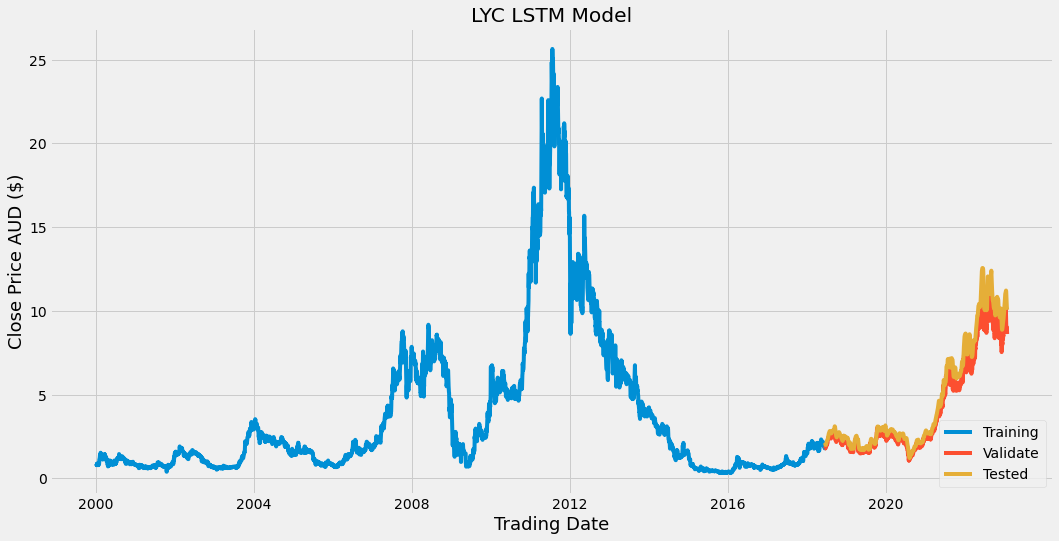

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('LYC LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/lyc_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_38176/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of          Close  Predictions  Difference
4617  1.790221     2.113244   -0.323023
4618  1.790221     2.065324   -0.275103
4619  1.824743     2.026559   -0.201816
4620  1.795153     2.006459   -0.211306
4621  1.864197     1.992606   -0.128409
...        ...          ...         ...
5766  8.840000    10.719594   -1.879594
5767  8.920000    10.453565   -1.533565
5768  9.030000    10.258309   -1.228310
5769  8.830000    10.155381   -1.325381
5770  8.620000    10.068029   -1.448030

[1154 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.wbc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $8.619999885559082 Predicted next day share price $23.61


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/lyc_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list lyc_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/lyc_model.sav')

In [32]:
# query the lyc collection and load into dataframe

df_mongo = pd.DataFrame(list(db.lyc.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[9.35      ],
       [9.52      ],
       [9.09      ],
       [8.31      ],
       [7.81      ],
       [8.5       ],
       [8.85      ],
       [8.47      ],
       [8.21      ],
       [8.49      ],
       [8.29      ],
       [8.24      ],
       [8.275     ],
       [8.87      ],
       [9.1       ],
       [8.79      ],
       [8.61      ],
       [8.78      ],
       [8.98      ],
       [8.95      ],
       [8.5       ],
       [7.925     ],
       [8.23      ],
       [7.94000006],
       [7.51999998],
       [7.42000008],
       [7.75      ],
       [7.80999994],
       [7.80000019],
       [7.92999983],
       [8.07999992],
       [8.13000011],
       [8.15999985],
       [8.22000027],
       [8.35999966],
       [8.27999973],
       [8.53999996],
       [8.61499977],
       [8.85999966],
       [8.80000019],
       [8.93000031],
       [9.13000011],
       [9.23999977],
       [9.40999985],
       [9.76000023],
       [9.77000046],
       [9.85999966],
       [9.670

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/lyc_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_lyc(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_lyc(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[8.83,
 8.8,
 8.82,
 8.86,
 8.91,
 8.97,
 9.04,
 9.11,
 9.18,
 9.25,
 9.33,
 9.4,
 9.48,
 9.56,
 9.65,
 9.73,
 9.82,
 9.9,
 9.99,
 10.09,
 10.18,
 10.28,
 10.39,
 10.5,
 10.61,
 10.72,
 10.81,
 10.92,
 11.04,
 11.14,
 11.25,
 11.36,
 11.48,
 11.59,
 11.71,
 11.84,
 11.96,
 12.09,
 12.22,
 12.36,
 12.51,
 12.66,
 12.81,
 12.97,
 13.14,
 13.31,
 13.49,
 13.67,
 13.86,
 14.06,
 14.27,
 14.48,
 14.7,
 14.93,
 15.17,
 15.41,
 15.67,
 15.93,
 16.2,
 16.49,
 16.74,
 17.03,
 17.33,
 17.64,
 17.95,
 18.27,
 18.61,
 18.95,
 19.3,
 19.66,
 20.03,
 20.41,
 20.8,
 21.21,
 21.62,
 22.05,
 22.49,
 22.94,
 23.41,
 23.89,
 24.38,
 24.88,
 25.4,
 25.94,
 26.49,
 27.06,
 27.64,
 28.24,
 28.86,
 29.5,
 30.16,
 30.83,
 31.53,
 32.24,
 32.98,
 33.74,
 34.53,
 35.33,
 36.16,
 37.02,
 37.9,
 38.81,
 39.74,
 40.71,
 41.7,
 42.72,
 43.77,
 44.85,
 45.97,
 47.11,
 48.29,
 49.51,
 50.76,
 52.05,
 53.37,
 54.74,
 56.14,
 57.59,
 59.07,
 60.6,
 62.18,
 63.81,
 65.48,
 67.19,
 68.96,
 70.79,
 72.66,
 74.59,
 76.58,


In [34]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [35]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')

#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')
today_str=today1.strftime('%d-%m-%Y')
print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')
    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)
    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[10:].values
    print(dates_val)

2022-08-31 00:00:00 2022-08-30 00:00:00
5:16:07.553400
[[ObjectId('630dc684ae0967d012939261') 11 '14-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939262') 12 '15-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939263') 13 '16-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939264') 14 '19-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d012939265') 15 '20-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d012939266') 16 '21-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939267') 17 '22-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939268') 18 '23-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939269') 19 '26-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d01293926a') 20 '27-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d01293926b') 21 '28-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d01293926c') 22 '29-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d01293926d') 23 '30-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d01293926e') 24 '03-10-2022' 'Monday']
 [ObjectId('630dc6

Friday 09-09-2022


C:\Users\antoi\AppData\Local\Temp/ipykernel_38176/91098407.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


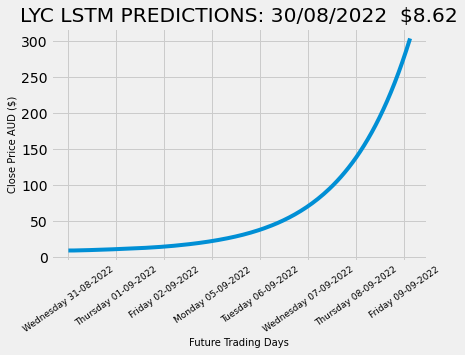

In [36]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
print(day8)
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('LYC LSTM PREDICTIONS: '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/lyc_pred.png', bbox_inches="tight")
plt.show()

In [37]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 8.83},
 {'Price': 8.8},
 {'Price': 8.82},
 {'Price': 8.86},
 {'Price': 8.91},
 {'Price': 8.97},
 {'Price': 9.04},
 {'Price': 9.11},
 {'Price': 9.18},
 {'Price': 9.25},
 {'Price': 9.33},
 {'Price': 9.4},
 {'Price': 9.48},
 {'Price': 9.56},
 {'Price': 9.65},
 {'Price': 9.73},
 {'Price': 9.82},
 {'Price': 9.9},
 {'Price': 9.99},
 {'Price': 10.09},
 {'Price': 10.18},
 {'Price': 10.28},
 {'Price': 10.39},
 {'Price': 10.5},
 {'Price': 10.61},
 {'Price': 10.72},
 {'Price': 10.81},
 {'Price': 10.92},
 {'Price': 11.04},
 {'Price': 11.14},
 {'Price': 11.25},
 {'Price': 11.36},
 {'Price': 11.48},
 {'Price': 11.59},
 {'Price': 11.71},
 {'Price': 11.84},
 {'Price': 11.96},
 {'Price': 12.09},
 {'Price': 12.22},
 {'Price': 12.36},
 {'Price': 12.51},
 {'Price': 12.66},
 {'Price': 12.81},
 {'Price': 12.97},
 {'Price': 13.14},
 {'Price': 13.31},
 {'Price': 13.49},
 {'Price': 13.67},
 {'Price': 13.86},
 {'Price': 14.06},
 {'Price': 14.27},
 {'Price': 14.48},
 {'Price': 14.7},
 {'Price': 14.93}

In [38]:
# len_df_mongo = len(df.index) # length of the original dataframe
len_df_mongo=len(df_mongo)
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4617 5771 5931


,Close
5920,235.59
5921,242.32
5922,249.25
5923,256.38
5924,263.73
5925,271.29
5926,279.08
5927,287.09
5928,295.34
5929,303.83


C:\Users\antoi\AppData\Local\Temp/ipykernel_38176/1830226815.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


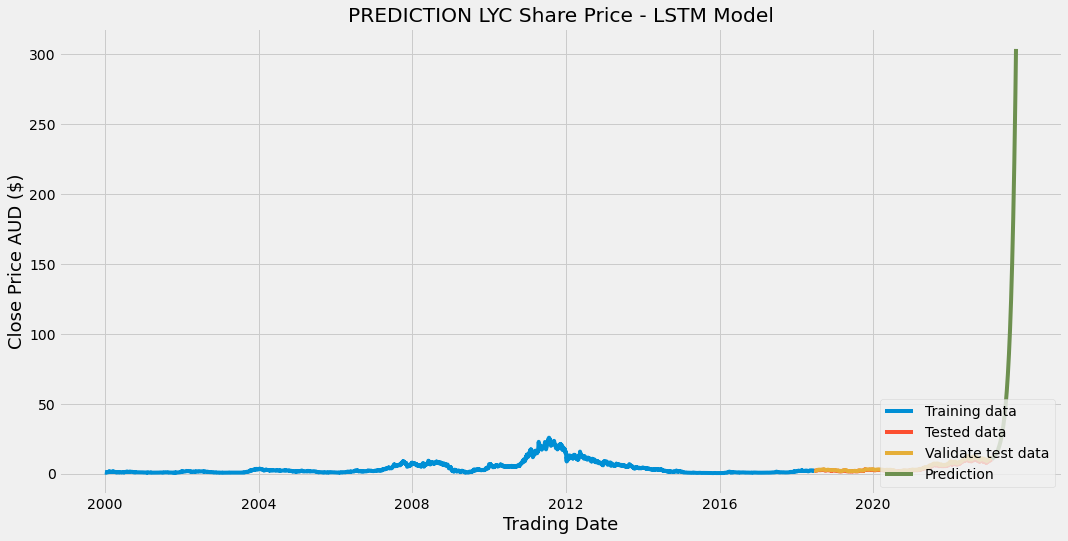

In [39]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION LYC Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/lyc_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [40]:
# Query all
name = 'LYC'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)


{'_id': ObjectId('62f8348e88f5e24597bc697a'), 'model': 'RFR', 'name': 'LYC', 'date': '12/08/2022', 'predicted': 6, 'actual': 9, 'difference': -2.6271, 'accuracy': 90.7}
{'_id': ObjectId('630c8ec185d5686c1b532820'), 'model': 'LSTM', 'name': 'LYC', 'date': '29/08/2022', 'predicted': 21.27, 'actual': 8.83, 'difference': 12.44, 'rmse': 0.19764}


In [41]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f8348e88f5e24597bc697a'), 'model': 'RFR', 'name': 'LYC', 'date': '12/08/2022', 'predicted': 6, 'actual': 9, 'difference': -2.6271, 'accuracy': 90.7}


In [42]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30/08/2022, predicted $23.61, actual $8.62, difference 14.99, rmse 0.50067


In [43]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f8348e88f5e24597bc697a'), 'model': 'RFR', 'name': 'LYC', 'date': '12/08/2022', 'predicted': 6, 'actual': 9, 'difference': -2.6271, 'accuracy': 90.7}
{'_id': ObjectId('630dcdcb45a6521a11c6e36b'), 'model': 'LSTM', 'name': 'LYC', 'date': '30/08/2022', 'predicted': 23.61, 'actual': 8.62, 'difference': 14.99, 'rmse': 0.50067}


In [44]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'